<a href="https://colab.research.google.com/github/mariusbiteau/Buildings_Electrical-Consumption_CO2-Emissions_Prediction/blob/main/Analysis_Buildings_Electrical_Consumption_CO2_Emissions_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of electrical consumption and CO2 emissions of non-residential buildings.

You work for the city of Seattle. To achieve its goal of a carbon-neutral city by 2050, your team is taking a close look at emissions from non-residential buildings.

### About the Dataset

This is a dataset hosted by the City of Seattle. The city has an open data platform found here and they update their information according the amount of data that is brought in. 

Update Frequency: This dataset is updated quarterly.

The datasets has as datapoint each building (TBD products) and for each, we have TBD columns which are separated in  sections :

TBD


### Project Goal

Thorough surveys have been carried out by your agents in 2015 and 2016. However, these readings are expensive to obtain, and based on those already taken, you want to try to predict the CO2 emissions and total energy consumption of buildings for which they have not yet been measured.

You are also looking to assess the value of the ENERGY STAR Score for emissions prediction, which is tedious to calculate with the approach your team is currently using.

Objectives of this analysis notebook :

- Perform a brief EDA.
- Test different prediction models in order to better answer the problem.

 have 2 variables to predict; the energy consumption of a site and its CO2 emissions. I also have to evaluate the interest of the Energy Star Score in predicting carbon emissions.

The energy consumption (kWh or kBtu) of a building is composed of different factors, in order of importance :

Its natural characteristics (placement, orientation, etc.),
Its level of insulation (attic, walls, glazing, etc.),
Its airtightness level (VMC, electrical boxes, gaskets, etc... ),
The performance of its equipment (hot water production, user equipment),
Its mode of heating (electricity, gas, wood, etc...)
CO2 emissions are regulated by direct and indirect factors. For example, an electrical energy produced by nuclear fission will emit less CO2 than an electrical energy produced by coal, this is an indirect factor. If heat is produced directly using natural gas, it is a direct factor in CO2 emissions.

We speak of emissions in grams per kWh or kBtu, so CO2 emissions are correlated to energy consumption.

The objective of this first work is to be able to extract the variables that best correspond to the criteria mentioned above, in order to obtain the most efficient models.

In [16]:
from google.colab import drive
from pandas_profiling import ProfileReport
import pandas as pd
import numpy as np
import math
import json

import seaborn as sns
import folium
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
plt.style.use('ggplot')
%matplotlib inline

pd.options.mode.chained_assignment = None

import six
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

## 1. Data Import

In [17]:
drive.mount('/content/drive')
csv_seattle = '/content/drive/My Drive/OC_DataScientist/P4/df_seattle_modelization.csv'
df = pd.read_csv(csv_seattle)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data Description

##### Show data header


In [18]:
df.head(3)

,Unnamed: 0,OSEBuildingID,DataYear,PropertyName,BuildingAge,PrimaryPropertyType,NumberofBuildings,Binned_Floors,PropertyGFATotal,GFABuildings_prop,ENERGYSTARScore,MainEnergy,SiteEnergyUse(kBtu),Electricity,NaturalGas,SteamUse,OtherFuelUse,GHGEmissions(MetricTonsCO2e),CouncilDistrictCode,Latitude,Longitude
0,0,1,2015,MAYFLOWER PARK HOTEL,88,Hotel,1.0,4.0,88434,1.000000,65.0,Electricity,6981428.0,0.527995,0.182253,0.289773,0.0,249.43,7,47.612190,-122.337997
1,1,2,2015,PARAMOUNT HOTEL,19,Hotel,1.0,4.0,103566,0.854547,51.0,NaturalGas,8354235.0,0.467477,0.532542,0.000000,0.0,263.51,7,47.613106,-122.333358
2,2,3,2015,WESTIN HOTEL,46,Hotel,1.0,4.0,961990,1.000000,18.0,Electricity,73130656.0,0.680459,0.050730,0.268839,0.0,2061.48,7,47.613349,-122.337699


##### Show data info


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102 entries, 0 to 3101
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    3102 non-null   int64  
 1   OSEBuildingID                 3102 non-null   int64  
 2   DataYear                      3102 non-null   int64  
 3   PropertyName                  3102 non-null   object 
 4   BuildingAge                   3102 non-null   int64  
 5   PrimaryPropertyType           3102 non-null   object 
 6   NumberofBuildings             3102 non-null   float64
 7   Binned_Floors                 3079 non-null   float64
 8   PropertyGFATotal              3102 non-null   int64  
 9   GFABuildings_prop             3102 non-null   float64
 10  ENERGYSTARScore               2065 non-null   float64
 11  MainEnergy                    3102 non-null   object 
 12  SiteEnergyUse(kBtu)           3102 non-null   float64
 13  Ele

##### Fix data types


In [20]:
df.PropertyName = df.PropertyName.astype('category')
df.PrimaryPropertyType = df.PrimaryPropertyType.astype('category')
df.MainEnergy = df.MainEnergy.astype('category')
df = df.drop(['Unnamed: 0'], axis=1)

Now, let's check our new data types and column names:

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102 entries, 0 to 3101
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   OSEBuildingID                 3102 non-null   int64   
 1   DataYear                      3102 non-null   int64   
 2   PropertyName                  3102 non-null   category
 3   BuildingAge                   3102 non-null   int64   
 4   PrimaryPropertyType           3102 non-null   category
 5   NumberofBuildings             3102 non-null   float64 
 6   Binned_Floors                 3079 non-null   float64 
 7   PropertyGFATotal              3102 non-null   int64   
 8   GFABuildings_prop             3102 non-null   float64 
 9   ENERGYSTARScore               2065 non-null   float64 
 10  MainEnergy                    3102 non-null   category
 11  SiteEnergyUse(kBtu)           3102 non-null   float64 
 12  Electricity                   3102 non-null   fl

##### Show statistical analysis of our data set
Let's show min, max, mean, std, and count of each column in the dataset.

In [22]:
df.describe()

,OSEBuildingID,DataYear,BuildingAge,NumberofBuildings,Binned_Floors,PropertyGFATotal,GFABuildings_prop,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity,NaturalGas,SteamUse,OtherFuelUse,GHGEmissions(MetricTonsCO2e),CouncilDistrictCode,Latitude,Longitude
count,3102.000000,3102.000000,3102.000000,3102.000000,3079.000000,3.102000e+03,3102.000000,2065.000000,3.102000e+03,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000
mean,15920.698259,2015.485816,53.815603,1.089297,2.443326,1.145883e+05,0.934572,63.848426,8.030760e+06,0.706203,0.273337,0.020395,0.000044,178.629001,4.382979,47.615868,-122.333445
std,13331.224511,0.499879,32.743955,1.169077,1.129937,1.977410e+05,0.150500,28.738155,2.082894e+07,0.260824,0.261913,0.089330,0.001321,657.974395,2.202357,0.047740,0.023942
min,1.000000,2015.000000,1.000000,0.000000,1.000000,1.128500e+04,-1.502318,1.000000,1.144100e+04,0.000000,0.000000,0.000000,0.000000,0.080000,1.000000,47.509435,-122.411820
25%,586.500000,2015.000000,27.000000,1.000000,1.000000,2.938000e+04,1.000000,45.000000,1.228871e+06,0.498926,0.000000,0.000000,0.000000,19.822500,2.000000,47.585957,-122.343233
50%,21125.000000,2015.000000,50.000000,1.000000,2.000000,4.885000e+04,1.000000,71.000000,2.602079e+06,0.721463,0.231826,0.000000,0.000000,49.060000,4.000000,47.612276,-122.333223
75%,24535.500000,2016.000000,86.000000,1.000000,3.000000,1.046775e+05,1.000000,88.000000,7.141995e+06,0.999998,0.484631,0.000000,0.000000,140.640000,7.000000,47.648351,-122.322623
max,50226.000000,2016.000000,116.000000,39.000000,4.000000,2.200000e+06,1.000029,100.000000,4.483853e+08,1.000087,1.000000,0.830998,0.046463,16870.980000,7.000000,47.733870,-122.258795


##### Show if there are missing datapoints¶


In [23]:
obj = df.isna().mean().round(4) * 100
for key,value in obj.iteritems():
    print(key,",",value)

OSEBuildingID , 0.0
DataYear , 0.0
PropertyName , 0.0
BuildingAge , 0.0
PrimaryPropertyType , 0.0
NumberofBuildings , 0.0
Binned_Floors , 0.74
PropertyGFATotal , 0.0
GFABuildings_prop , 0.0
ENERGYSTARScore , 33.43
MainEnergy , 0.0
SiteEnergyUse(kBtu) , 0.0
Electricity , 0.0
NaturalGas , 0.0
SteamUse , 0.0
OtherFuelUse , 0.0
GHGEmissions(MetricTonsCO2e) , 0.0
CouncilDistrictCode , 0.0
Latitude , 0.0
Longitude , 0.0


In [24]:
print(df.isnull().sum())

OSEBuildingID                      0
DataYear                           0
PropertyName                       0
BuildingAge                        0
PrimaryPropertyType                0
NumberofBuildings                  0
Binned_Floors                     23
PropertyGFATotal                   0
GFABuildings_prop                  0
ENERGYSTARScore                 1037
MainEnergy                         0
SiteEnergyUse(kBtu)                0
Electricity                        0
NaturalGas                         0
SteamUse                           0
OtherFuelUse                       0
GHGEmissions(MetricTonsCO2e)       0
CouncilDistrictCode                0
Latitude                           0
Longitude                          0
dtype: int64


[Text(29.5, 0.5, 'Data Points'),
 Text(0.5, 11.5, 'Columns'),
 Text(0.5, 1.0, 'Missing Data')]

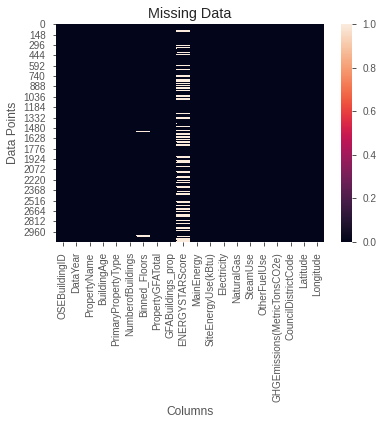

In [25]:
sns.heatmap(df.isnull()).set(title = 'Missing Data', xlabel = 'Columns', ylabel = 'Data Points')

We can see from above that we have some missing data points, but it is not extensive and it mainly concerns the energystar score feature.

We will now process these missing data points

In [26]:
df.loc[df['Binned_Floors'].isnull()]

,OSEBuildingID,DataYear,PropertyName,BuildingAge,PrimaryPropertyType,NumberofBuildings,Binned_Floors,PropertyGFATotal,GFABuildings_prop,ENERGYSTARScore,MainEnergy,SiteEnergyUse(kBtu),Electricity,NaturalGas,SteamUse,OtherFuelUse,GHGEmissions(MetricTonsCO2e),CouncilDistrictCode,Latitude,Longitude
154,267,2015,PINE ST. CONDO-ELLIOTT GRAND HYATT SEATTLE,16,Hotel,1.0,NaN,934292,1.000000,NaN,Electricity,63811044.00,0.621648,0.378378,0.000000,0.0,1558.85,7,47.612677,-122.333932
464,656,2015,1221 MADISON STREET (FORMER ARNOLD MED. PAVILLON),11,Office,1.0,NaN,225982,1.000000,61.0,Electricity,18558162.00,0.635452,0.000000,0.364574,0.0,604.45,3,47.609680,-122.323105
465,657,2015,2200 WESTLAKE,9,Other,1.0,NaN,516407,1.000000,19.0,Electricity,48981052.00,0.610087,0.389938,0.000000,0.0,1222.69,7,47.617939,-122.337387
536,758,2015,PACIFIC PLACE,16,Other,1.0,NaN,947987,0.535663,NaN,Electricity,48143224.00,1.000041,0.000000,0.000000,0.0,335.63,7,47.612874,-122.335276
1137,24086,2015,KING COUNTY METRO TRANSIT ATLANTIC-CENTRAL BAS...,24,Other,10.0,NaN,180796,1.000000,NaN,Electricity,29939196.00,0.558467,0.441556,0.000000,0.0,818.66,2,47.591130,-122.323399
1538,40028,2015,"SAND POINT BUILDING 5A,5B,5C,5D",75,Warehouse,1.0,NaN,384772,1.000000,65.0,Electricity,15411831.00,0.579122,0.420902,0.000000,0.0,406.74,4,47.683844,-122.261760
1539,40031,2015,SAND POINT BUILDING 25,55,Office,1.0,NaN,30287,1.000000,56.0,Electricity,1976647.00,0.845482,0.154553,0.000000,0.0,27.88,4,47.682195,-122.262390
1540,40034,2015,SAND POINT BUILDING 29,55,Office,1.0,NaN,21931,1.000000,21.0,NaturalGas,3732139.00,0.351837,0.648178,0.000000,0.0,137.63,4,47.682195,-122.262946
1546,43948,2015,GEORGETOWN STEAM PLANT,109,Other,1.0,NaN,39212,1.000000,NaN,Electricity,773013.00,1.000041,0.000000,0.000000,0.0,5.39,2,47.561588,-122.316071
1555,49705,2015,MAGNUSON PARK CAMPUS,86,Other,7.0,NaN,502030,1.000000,NaN,Electricity,17290816.00,0.558767,0.441256,0.000000,0.0,472.56,4,47.683179,-122.258795


In [27]:
df.loc[df["OSEBuildingID"] == 267,"Binned_Floors"] = 4
df.loc[df["OSEBuildingID"] == 656,"Binned_Floors"] = 4
df.loc[df["OSEBuildingID"] == 657,"Binned_Floors"] = 4
df.loc[df["OSEBuildingID"] == 758,"Binned_Floors"] = 4
df.loc[df["OSEBuildingID"] == 21611,"Binned_Floors"] = 2
df.loc[df["OSEBuildingID"] == 24086,"Binned_Floors"] = 2
df.loc[df["OSEBuildingID"] == 40028,"Binned_Floors"] = 2
df.loc[df["OSEBuildingID"] == 40031,"Binned_Floors"] = 3
df.loc[df["OSEBuildingID"] == 40034,"Binned_Floors"] = 3
df.loc[df["OSEBuildingID"] == 49705,"Binned_Floors"] = 1
df.loc[df["OSEBuildingID"] == 43948,"Binned_Floors"] = 4
df.loc[df["OSEBuildingID"] == 49958,"Binned_Floors"] = 2
df.loc[df["OSEBuildingID"] == 49966,"Binned_Floors"] = 1
df.loc[df["OSEBuildingID"] == 23311,"Binned_Floors"] = 4

In [28]:
df = df[df.ENERGYSTARScore.notna()]
df.shape

(2065, 20)

In [29]:
print(df.isnull().sum())

OSEBuildingID                   0
DataYear                        0
PropertyName                    0
BuildingAge                     0
PrimaryPropertyType             0
NumberofBuildings               0
Binned_Floors                   0
PropertyGFATotal                0
GFABuildings_prop               0
ENERGYSTARScore                 0
MainEnergy                      0
SiteEnergyUse(kBtu)             0
Electricity                     0
NaturalGas                      0
SteamUse                        0
OtherFuelUse                    0
GHGEmissions(MetricTonsCO2e)    0
CouncilDistrictCode             0
Latitude                        0
Longitude                       0
dtype: int64


## 2. EDA

### Panda Profiling

In [30]:
#profile = ProfileReport(df, title="Heart Dataset", html={'style': {'full_width' : True}})

In [31]:
#profile.to_notebook_iframe()

### 2.1 Univariate Analysis: Numerical Variable

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

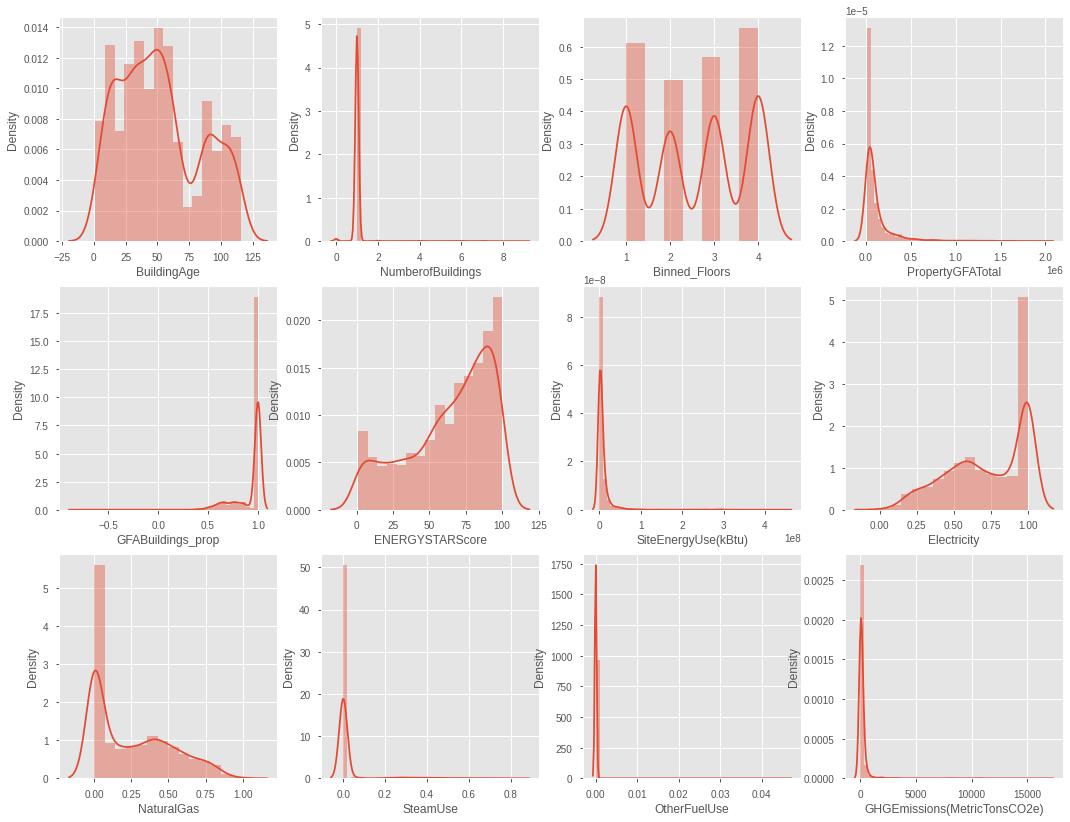

In [32]:
def plot_multiple_histograms(df, cols):
    matplotlib.rcParams['figure.figsize'] = (18,14)
    num_plots = len(cols)
    num_cols = math.ceil(np.sqrt(num_plots))
    num_rows = math.ceil(num_plots/num_cols)
        
    fig, axs = plt.subplots(num_rows, num_cols)
    
    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
            
        if num_rows == 1:
            if num_cols == 1:
                sns.distplot(df[col], kde=True, ax=axs)
            else:
                sns.distplot(df[col], kde=True, ax=axs[j])
        else:
            sns.distplot(df[col], kde=True, ax=axs[i, j])

            
plot_multiple_histograms(df, ["BuildingAge","NumberofBuildings", "Binned_Floors", "PropertyGFATotal", "GFABuildings_prop", "ENERGYSTARScore", "SiteEnergyUse(kBtu)", "Electricity", "NaturalGas", "SteamUse", "OtherFuelUse", "GHGEmissions(MetricTonsCO2e)"])


matplotlib.rcParams["figure.figsize"] = [6.4, 4.8]


### 2.2 Univariate Analysis: Categorical Variables


[Text(0, 0, 'Office'),
 Text(0, 0, 'Warehouse'),
 Text(0, 0, 'Supermarket/Grocery/Retail Store'),
 Text(0, 0, 'School/University'),
 Text(0, 0, 'Hotel'),
 Text(0, 0, 'Worship Facility'),
 Text(0, 0, 'Distribution Center'),
 Text(0, 0, 'Other'),
 Text(0, 0, 'Hospital/Laboratory'),
 Text(0, 0, 'Restaurant')]

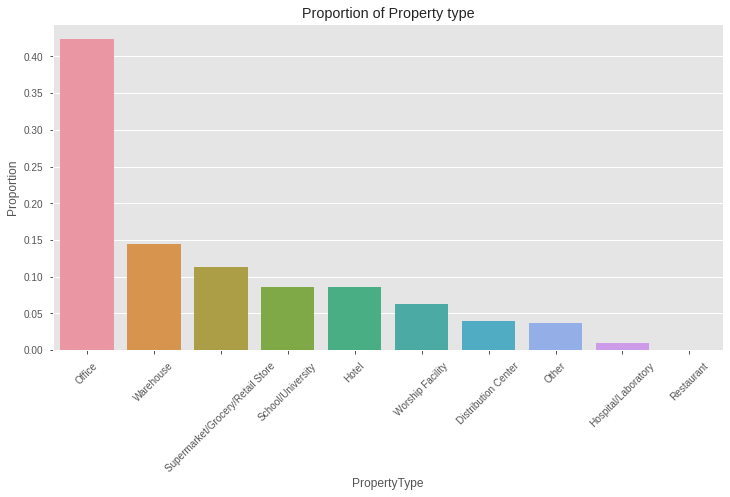

In [33]:
x, y = "PropertyType", "Proportion"

prop_df = (df["PrimaryPropertyType"]
           .value_counts(normalize=True)
           .rename_axis(x)
           .rename(y)
           .reset_index())

fig = plt.figure(figsize=(12, 6))
g = sns.barplot(x=x, y=y, data=prop_df, order=prop_df[x])
g.set(title = 'Proportion of Property type')
g.set_xticklabels(g.get_xticklabels(),rotation=45)

[Text(0.5, 1.0, 'Proportion of Main Energy type')]

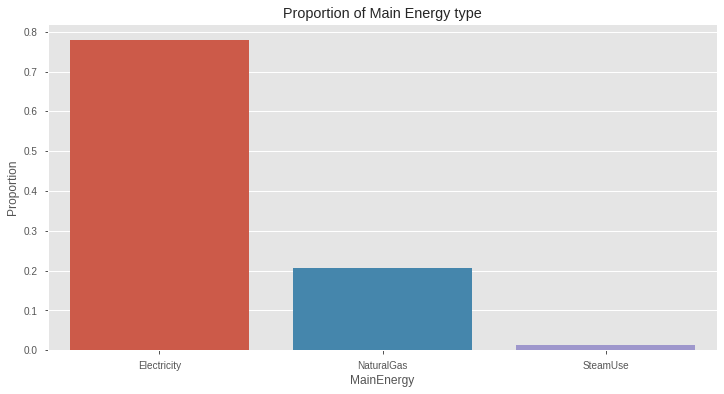

In [34]:
x, y = "MainEnergy", "Proportion"

prop_df = (df["MainEnergy"]
           .value_counts(normalize=True)
           .rename_axis(x)
           .rename(y)
           .reset_index())

fig = plt.figure(figsize=(12, 6))
g = sns.barplot(x=x, y=y, data=prop_df, order=prop_df[x])
g.set(title = 'Proportion of Main Energy type')

### 2.3 Multivariate Analysis: Categorical vs Numerical Variables 

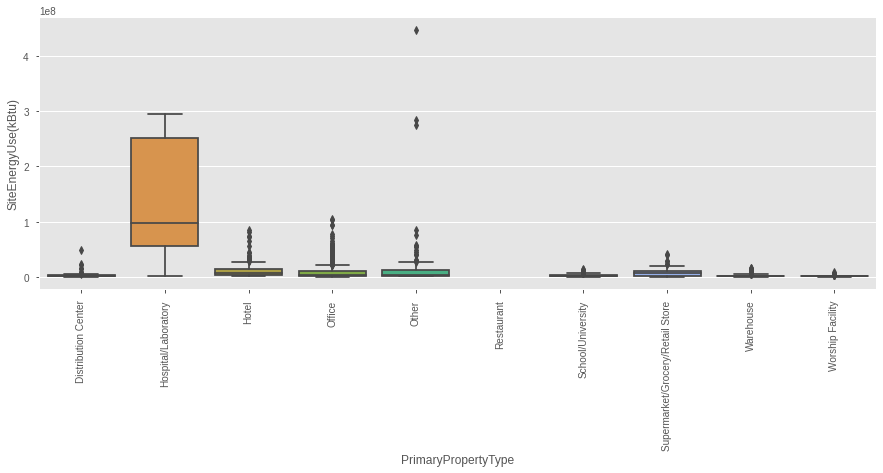

In [35]:
fig = plt.figure(1, figsize=(15,5))
sns.boxplot(data=df, x="PrimaryPropertyType" , y="SiteEnergyUse(kBtu)", showfliers=True)
plt.xticks(rotation=90)
plt.show()

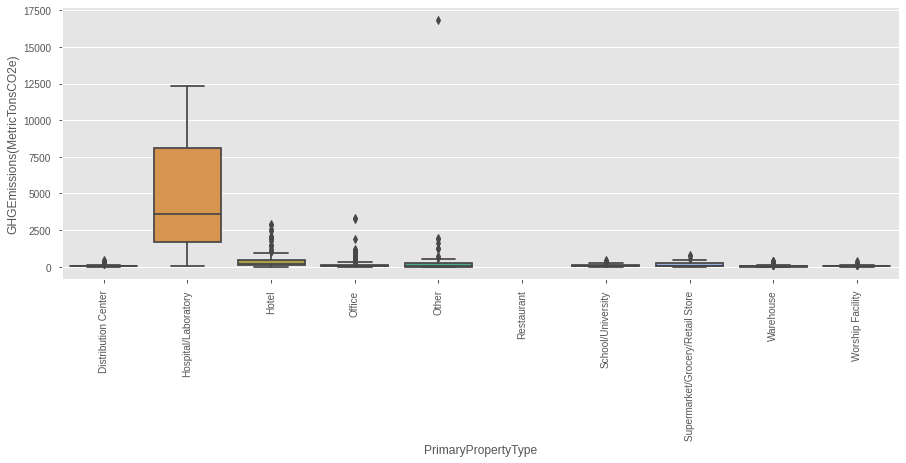

In [36]:
fig = plt.figure(1, figsize=(15,5))
sns.boxplot(data=df, x="PrimaryPropertyType" , y="GHGEmissions(MetricTonsCO2e)", showfliers=True)
plt.xticks(rotation=90)
plt.show()

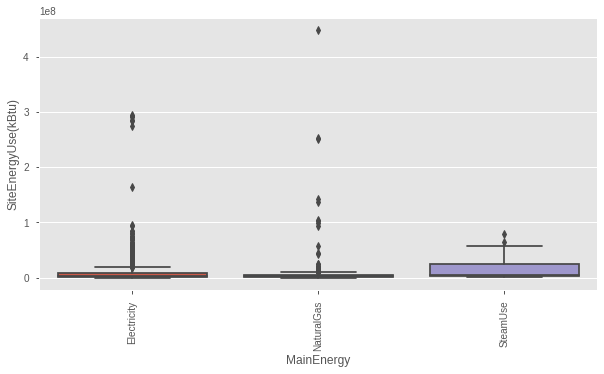

In [37]:
fig = plt.figure(1, figsize=(10,5))
sns.boxplot(data=df, x="MainEnergy" , y="SiteEnergyUse(kBtu)", showfliers=True)
plt.xticks(rotation=90)
plt.show()

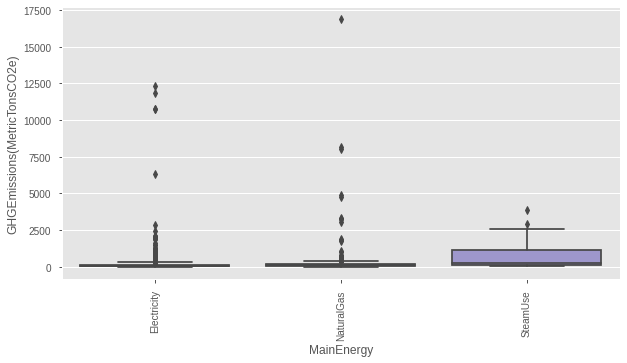

In [38]:
fig = plt.figure(1, figsize=(10,5))
sns.boxplot(data=df, x="MainEnergy" , y="GHGEmissions(MetricTonsCO2e)", showfliers=True)
plt.xticks(rotation=90)
plt.show()

### 2.4 Geographical Analysis


#### *Heatmap*

In [39]:
def get_center_latlong(df):
    # get the center of my map for plotting
    centerlat = (df['Latitude'].max() + df['Latitude'].min()) / 2
    centerlong = (df['Longitude'].max() + df['Longitude'].min()) / 2
    return centerlat, centerlong

In [40]:
def generateBaseMap(center = get_center_latlong(df), default_zoom_start=11.5):
    base_map = folium.Map(location = center, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [41]:
from folium.plugins import HeatMap
df['count'] = 1
base_map = generateBaseMap()
HeatMap(data = df[['Latitude', 'Longitude', 'count']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

#### *Choropleth Map*

In [42]:
boundary_file = '/content/drive/My Drive/OC_DataScientist/P4/Seattle-council-districts.geojson'
with open(boundary_file, 'r') as f:
    district_boundary = json.load(f)

In [43]:
# this line just to force our dataset zipcodes from numbers to strings so they match our geojson file
df['CouncilDistrictCode'] = pd.to_numeric(df.CouncilDistrictCode, errors='coerce')

# Grab my map center again using our created function (same as before)
center = get_center_latlong(df)


# Initialize Folium Map again (same as before)
seattle_map = folium.Map(location=center, zoom_start=11.5)

# Use the groupby method to have the mean of energy use by district
district_data = df.groupby('CouncilDistrictCode').aggregate(np.mean)
district_data.reset_index(inplace = True)

# Create choropleth map  
folium.Choropleth(
    geo_data=district_boundary,
    name='choropleth',
    data=district_data,
    columns=['CouncilDistrictCode', 'SiteEnergyUse(kBtu)'],
    key_on='feature.properties.district',
    fill_color='Spectral',
    fill_opacity=0.60,
      nan_fill_opacity=0,
    line_opacity=0.5,
    legend_name='Energy Use (kBtu)').add_to(seattle_map)

display(seattle_map)

### 2.4 Correlation


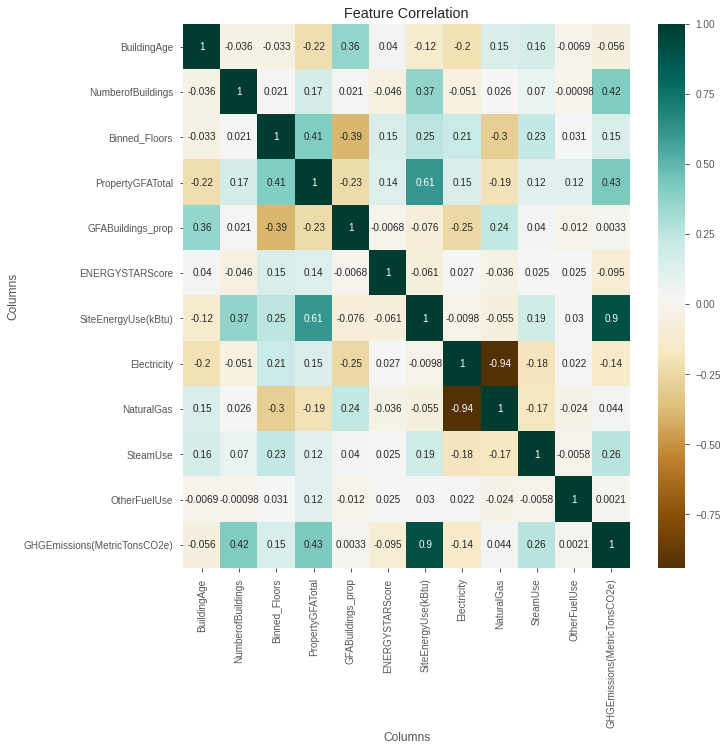

In [44]:
df_corr = df[["BuildingAge", "NumberofBuildings", "Binned_Floors", "PropertyGFATotal", "GFABuildings_prop", "ENERGYSTARScore", "SiteEnergyUse(kBtu)", "Electricity", "NaturalGas", "SteamUse", "OtherFuelUse", "GHGEmissions(MetricTonsCO2e)"]]

fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df_corr.corr(), annot=True, ax=ax, cmap='BrBG').set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns')
plt.show()

- High correlation between SiteEnergyUse(kBtu) and GHGEmissions(MetricTonsCO2e)
- High correlation between NaturalGas and Electricity
- Medium correlation between energy use and the property GFA total



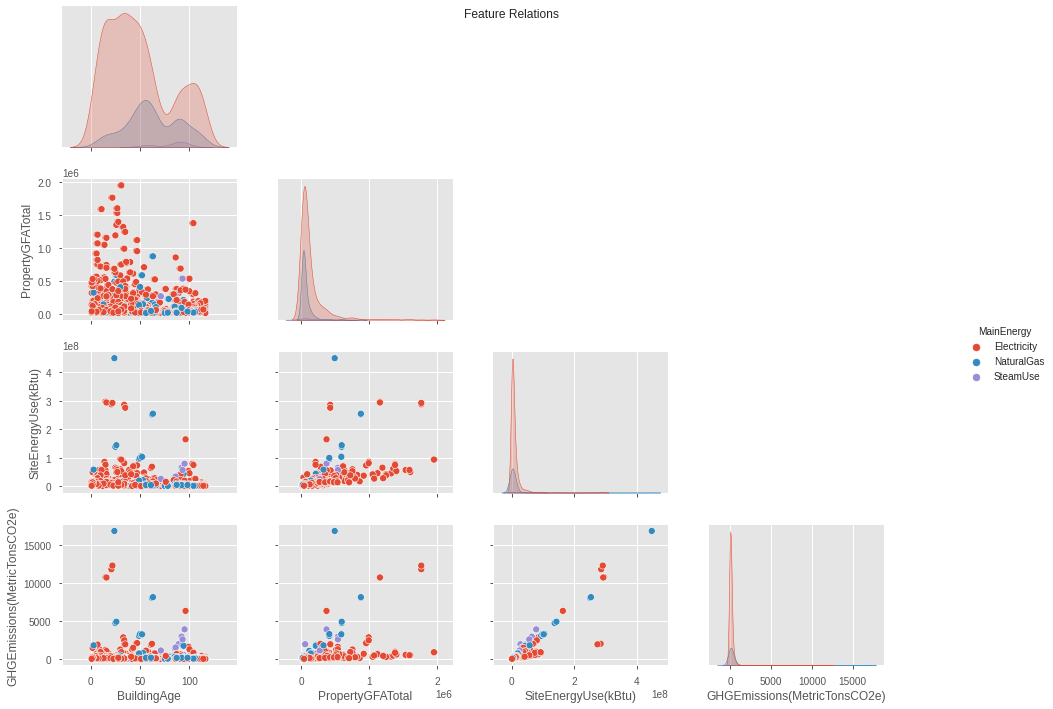

In [45]:
g = sns.pairplot(df[["BuildingAge", "PropertyGFATotal", "SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)", "MainEnergy"]], hue = 'MainEnergy', corner = True)
g.fig.suptitle('Feature Relations')
g.fig.set_size_inches(15,10)
plt.show()

## 3. Data Pre-Conditioning¶

In this section we will make our data ready for model training. This will include:

1. Transform our categorical column into numerical values.
2. Split data set into training and testing parts (80/20), while dropping the category column (string, and not going to be used to train the models), and separating cateogrical, where it will be used as labels.
3. We will try different splits of our dataset : with/without feature logging ; with.without duplicates.

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2065 entries, 0 to 3086
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   OSEBuildingID                 2065 non-null   int64   
 1   DataYear                      2065 non-null   int64   
 2   PropertyName                  2065 non-null   category
 3   BuildingAge                   2065 non-null   int64   
 4   PrimaryPropertyType           2065 non-null   category
 5   NumberofBuildings             2065 non-null   float64 
 6   Binned_Floors                 2065 non-null   float64 
 7   PropertyGFATotal              2065 non-null   int64   
 8   GFABuildings_prop             2065 non-null   float64 
 9   ENERGYSTARScore               2065 non-null   float64 
 10  MainEnergy                    2065 non-null   category
 11  SiteEnergyUse(kBtu)           2065 non-null   float64 
 12  Electricity                   2065 non-null   fl

#### *Features Selection*

In [47]:
df_final = df[["OSEBuildingID", "DataYear", "BuildingAge", "PrimaryPropertyType", "NumberofBuildings", "Binned_Floors", "PropertyGFATotal", "GFABuildings_prop", "ENERGYSTARScore", "SiteEnergyUse(kBtu)", "MainEnergy", "Electricity", "NaturalGas", "SteamUse", "OtherFuelUse", "GHGEmissions(MetricTonsCO2e)"]]

#### *PrimaryPropertyType Transform*

In [48]:
df_final = pd.get_dummies(df_final, drop_first=True)
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2065 entries, 0 to 3086
Data columns (total 25 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   OSEBuildingID                                         2065 non-null   int64  
 1   DataYear                                              2065 non-null   int64  
 2   BuildingAge                                           2065 non-null   int64  
 3   NumberofBuildings                                     2065 non-null   float64
 4   Binned_Floors                                         2065 non-null   float64
 5   PropertyGFATotal                                      2065 non-null   int64  
 6   GFABuildings_prop                                     2065 non-null   float64
 7   ENERGYSTARScore                                       2065 non-null   float64
 8   SiteEnergyUse(kBtu)                                   2065

In [49]:
df_final.head(5)

,OSEBuildingID,DataYear,BuildingAge,NumberofBuildings,Binned_Floors,PropertyGFATotal,GFABuildings_prop,ENERGYSTARScore,SiteEnergyUse(kBtu),Electricity,NaturalGas,SteamUse,OtherFuelUse,GHGEmissions(MetricTonsCO2e),PrimaryPropertyType_Hospital/Laboratory,PrimaryPropertyType_Hotel,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Restaurant,PrimaryPropertyType_School/University,PrimaryPropertyType_Supermarket/Grocery/Retail Store,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,MainEnergy_NaturalGas,MainEnergy_SteamUse
0,1,2015,88,1.0,4.0,88434,1.000000,65.0,6981428.0,0.527995,0.182253,0.289773,0.0,249.43,0,1,0,0,0,0,0,0,0,0,0
1,2,2015,19,1.0,4.0,103566,0.854547,51.0,8354235.0,0.467477,0.532542,0.000000,0.0,263.51,0,1,0,0,0,0,0,0,0,1,0
2,3,2015,46,1.0,4.0,961990,1.000000,18.0,73130656.0,0.680459,0.050730,0.268839,0.0,2061.48,0,1,0,0,0,0,0,0,0,0,0
3,5,2015,89,1.0,4.0,61320,1.000000,1.0,28229320.0,0.098090,0.070915,0.830998,0.0,1936.34,0,1,0,0,0,0,0,0,0,0,1
4,8,2015,35,1.0,4.0,119890,0.896071,67.0,14829099.0,0.409077,0.590940,0.000000,0.0,507.70,0,1,0,0,0,0,0,0,0,1,0


#### *Data Split 1: With Duplicates ; Without logging of high variance features*

In [50]:
y = df_final['SiteEnergyUse(kBtu)']
X = df_final.drop(['SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)'], axis=1)
seed = 101
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

#### *Data Split 2: With Duplicates ; With logging of high variance features*

In [51]:
df_final.var().sort_values(ascending=False).head(5)

SiteEnergyUse(kBtu)             5.440853e+14
PropertyGFATotal                4.358025e+10
OSEBuildingID                   1.689412e+08
GHGEmissions(MetricTonsCO2e)    5.681782e+05
BuildingAge                     1.007742e+03
dtype: float64

In [52]:
df_final2 = df_final.copy()
logl = ['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']

for i in logl:
    df_final2[i + '_log'] = np.log(df_final2[i])
    df_final2.drop(i, axis=1, inplace=True)

y2 = df_final2['SiteEnergyUse(kBtu)_log']
X2 = df_final2.drop(['SiteEnergyUse(kBtu)_log','GHGEmissions(MetricTonsCO2e)_log'], axis=1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=seed)

#### *Data Split 3: Without Duplicates ; Without logging of high variance features*

In [53]:
df_final3 = df_final.sort_values(by=['OSEBuildingID', 'DataYear']).drop_duplicates('OSEBuildingID', keep='last')
y3 = df_final3['SiteEnergyUse(kBtu)']
X3 = df_final3.drop(['SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)'], axis=1)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=seed)

#### *Data Split 4: Without Duplicates ; With logging of high variance features*

In [54]:
df_final4 = df_final2.sort_values(by=['OSEBuildingID', 'DataYear']).drop_duplicates('OSEBuildingID', keep='last')
y4 = df_final4['SiteEnergyUse(kBtu)_log']
X4 = df_final4.drop(['SiteEnergyUse(kBtu)_log','GHGEmissions(MetricTonsCO2e)_log'], axis=1)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=seed)

### Functions

In [55]:
def export_png_table(data, col_width=2.2, row_height=0.625, font_size=10,
                     header_color='#7451eb', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=1,
                     ax=None, filename='table.png', **kwargs):
    ax = None
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])

    fig.savefig(filename, dpi=500, quality=95, transparent=True)
    return ax

In [56]:
def evaluate_estimators(X_train, X_test, y_train, y_test, estimators, cv=5, scoring='neg_root_mean_squared_error', target_name='target'):
    """Evalue les modèles en estimant les meilleurs hyperparamètres. Crée un PNG des résultats.

    Args:
        X_train (object): Données d'entrainements
        X_test (object): Données de tests
        y_train (object): Données d'entrainements
        y_test (object): Données de tests
        estimators (dict): Contient les modèles et les hyperparamètres à tester
        cv (int, optional): Nombre de cross-validation. Defaults to 5.
        scoring (str, optional): Métrique d'évaluation des modèles. Defaults to 'neg_root_mean_squared_error'.
        target_name (str, optional): Nom de la cible. Defaults to 'target'.

    Returns:
        None
    """
    
    results = pd.DataFrame()
    for estim_name, estim, estim_params in estimators:
        print(f"{estim_name} en cours d'exécution...")
        model = GridSearchCV(estim, param_grid=estim_params, cv=cv, scoring=scoring, n_jobs=4)
        model.fit(X_train, y_train)

        # Je stocke les résultats du GridSearchCV dans un dataframe
        model_results_df = pd.DataFrame(model.cv_results_)

        # Je sélectionne la meilleure observations
        model_results_df = model_results_df[model_results_df["rank_test_score"] == 1]

        # J'ajoute le nom du modéle et les résultats sur les données de test
        model_results_df[target_name] = estim_name
        model_results_df['Test : R2'] = metrics.r2_score(y_test, model.predict(X_test))
        model_results_df['Test : RMSE'] = model.score(X_test, y_test)


        # Les hyperparamètres des estimateurs étant changeant, je crée un nouveau dataframe à partir de la colonne params           des résultats. Je jointe les 2 dataframes à partir des index. Cela me permet des flexible pour mon dataframe.
        model_results_df = pd.merge(model_results_df[[target_name,'Test : RMSE', 'Test : R2', 'mean_test_score', 'std_test_score']], 
                                 pd.DataFrame(model.cv_results_['params']), 
                                 left_index=True, right_index=True)
    
        # Je stocke les résultats dans un nouveau dataframe.
        results = results.append(model_results_df)

    
    export_png_table(round(results,4), filename='img_results_' + target_name + '.png')

    return None

## 4. Modelization of the energy use


### Linear Regression 
We will use the result of the dummy regressor as a reference (other methods should have better results)

##### Model Training

In [57]:
lm1 = LinearRegression()
lm1.fit(X_train,y_train)

lm2 = LinearRegression()
lm2.fit(X2_train,y2_train)

lm3 = LinearRegression()
lm3.fit(X3_train,y3_train)

lm4 = LinearRegression()
lm4.fit(X4_train,y4_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

##### Predictions

In [58]:
lm1_pred = lm1.predict(X_test)
lm2_pred = lm2.predict(X2_test)
lm3_pred = lm3.predict(X3_test)
lm4_pred = lm4.predict(X4_test)

##### Evaluation

Linear Regression Performance:

with duplicates, No logging:
MAE: 4590187.177995283
RMSE: 9431074.94486526
R2_Score:  0.7368528510209706

with duplicates, With logging:
MAE: 0.4774240164564395
RMSE: 0.613710815602197
R2_Score:  0.7869733283718695

no duplicates, No logging:
MAE: 5176563.778135515
RMSE: 17967855.937344294
R2_Score:  0.19652009745730536

no duplicates, With logging:
MAE: 0.4809623270847424
RMSE: 0.6667700527200316
R2_Score:  0.7335146813771356


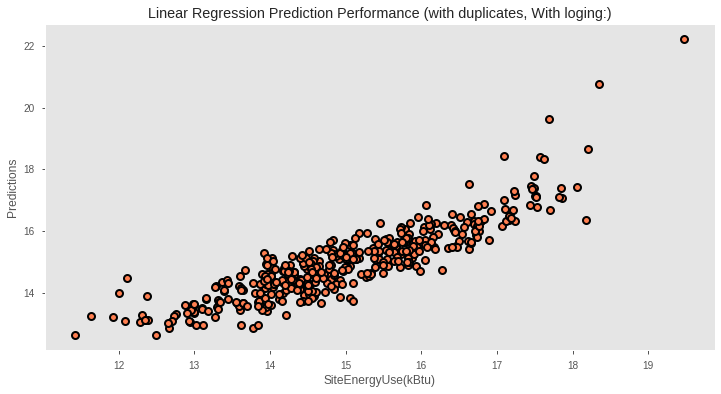

In [59]:

print('Linear Regression Performance:')

print('\nwith duplicates, No logging:')
print('MAE:', metrics.mean_absolute_error(y_test, lm1_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lm1_pred)))
print('R2_Score: ', metrics.r2_score(y_test, lm1_pred))

print('\nwith duplicates, With logging:')
print('MAE:', metrics.mean_absolute_error(y2_test, lm2_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2_test, lm2_pred)))
print('R2_Score: ', metrics.r2_score(y2_test, lm2_pred))

print('\nno duplicates, No logging:')
print('MAE:', metrics.mean_absolute_error(y3_test, lm3_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y3_test, lm3_pred)))
print('R2_Score: ', metrics.r2_score(y3_test, lm3_pred))

print('\nno duplicates, With logging:')
print('MAE:', metrics.mean_absolute_error(y4_test, lm4_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y4_test, lm4_pred)))
print('R2_Score: ', metrics.r2_score(y4_test, lm4_pred))

fig = plt.figure(figsize=(12, 6))
plt.scatter(y2_test,lm2_pred,color='coral', linewidths=2, edgecolors='k')
plt.xlabel('SiteEnergyUse(kBtu)') 
plt.ylabel('Predictions') 
plt.title('Linear Regression Prediction Performance (with duplicates, With loging:)') 
plt.grid(True)
plt.show()

From the metrics above, it is clear that logging and duplicates are essential for linear regression model training, in order to get acceptable results on this dataset. 

### Random Forest 

##### Training

In [60]:
rf1 = RandomForestRegressor(random_state=101, n_estimators=200)
rf2 = RandomForestRegressor(random_state=101, n_estimators=200)
rf4 = RandomForestRegressor(random_state=101, n_estimators=200)

rf1.fit(X_train, y_train)
rf2.fit(X2_train, y2_train)
rf4.fit(X4_train, y4_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=101, verbose=0, warm_start=False)

##### Predictions

In [61]:
rf1_pred = rf1.predict(X_test)
rf2_pred = rf2.predict(X2_test)
rf4_pred = rf4.predict(X4_test)

##### Evaluation

Random Forest Performance:

With duplicates, No logging:
MAE: 2198333.3550711614
RMSE: 6571472.992642198
R2_Score:  0.8722379911384741

With duplicates, With logging:
MAE: 0.2536562592776549
RMSE: 0.3782477212720016
R2_Score:  0.9190794048058247

No duplicates, With logging:
MAE: 0.3484701560653494
RMSE: 0.5235665898878794
R2_Score:  0.8356896325631931


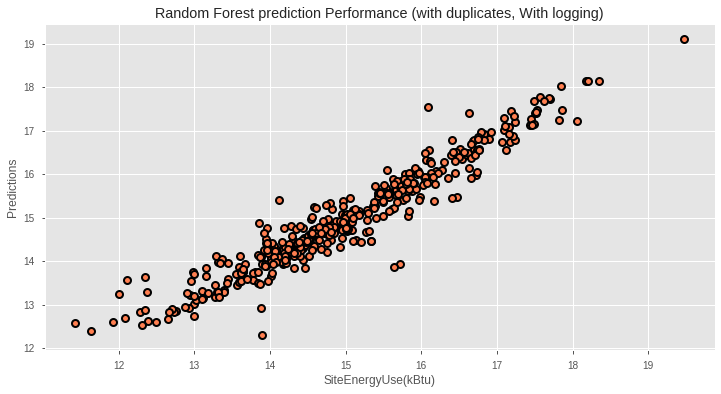

In [62]:
print('Random Forest Performance:')

print('\nWith duplicates, No logging:')
print('MAE:', metrics.mean_absolute_error(y_test, rf1_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf1_pred)))
print('R2_Score: ', metrics.r2_score(y_test, rf1_pred))

print('\nWith duplicates, With logging:')
print('MAE:', metrics.mean_absolute_error(y2_test, rf2_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2_test, rf2_pred)))
print('R2_Score: ', metrics.r2_score(y2_test, rf2_pred))

print('\nNo duplicates, With logging:')
print('MAE:', metrics.mean_absolute_error(y4_test, rf4_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y4_test, rf4_pred)))
print('R2_Score: ', metrics.r2_score(y4_test, rf4_pred))

fig = plt.figure(figsize=(12, 6))

plt.scatter(y2_test,rf2_pred,color='coral', linewidths=2, edgecolors='k')
plt.xlabel('SiteEnergyUse(kBtu)') 
plt.ylabel('Predictions') 
plt.title('Random Forest prediction Performance (with duplicates, With logging)') 
plt.grid(True)
plt.show()

##### Optimization
We will use grid search in order to obtain good parameters for our RF regressor. Of course our optimization here will be limited due to time and computing power constraints. The parameters we will optimize are:

- n-estimators
- min_samples_leaf
- max_depth
- max_features
- bootstrap

In [66]:
rf_param_grid = {'bootstrap': [True],
    'max_depth': [50, 75, 100],
    'max_features': ['auto', 15, 25],
    'min_samples_leaf': [3, 4, 5],
    'n_estimators': [200, 500, 1000]}

In [67]:
rf_grid = GridSearchCV(estimator= RandomForestRegressor(), param_grid = rf_param_grid,  n_jobs=-1, verbose=0)

In [68]:
rf_grid.fit(X2_train,y2_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [69]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 15,
 'min_samples_leaf': 3,
 'n_estimators': 200}

In [70]:
rf_opti = rf_grid.best_estimator_
rf_opti

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=15, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [71]:
rf_grid_predictions = rf_opti.predict(X2_test)

MAE: 0.2929033698807271
RMSE: 0.42292703061012676
R2_Score:  0.8988333628062064


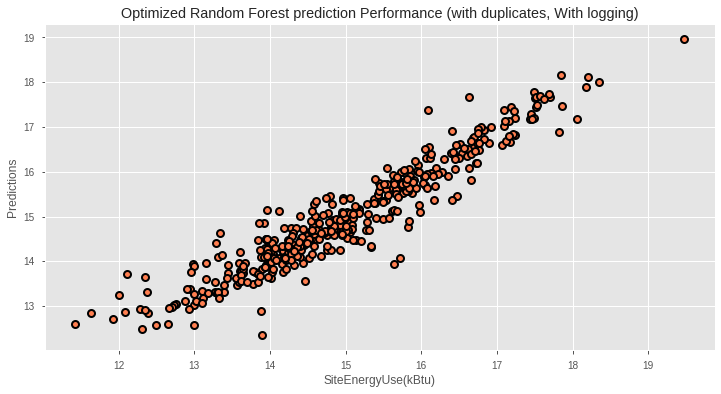

In [72]:
print('MAE:', metrics.mean_absolute_error(y2_test, rf_grid_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2_test, rf_grid_predictions)))
print('R2_Score: ', metrics.r2_score(y2_test, rf_grid_predictions))

fig = plt.figure(figsize=(12, 6))
plt.scatter(y2_test,rf_grid_predictions,color='coral', linewidths=2, edgecolors='k')
plt.xlabel('SiteEnergyUse(kBtu)') 
plt.ylabel('Predictions') 
plt.title('Optimized Random Forest prediction Performance (with duplicates, With logging)') 
plt.grid(True)
plt.show()

##### Feature Importance

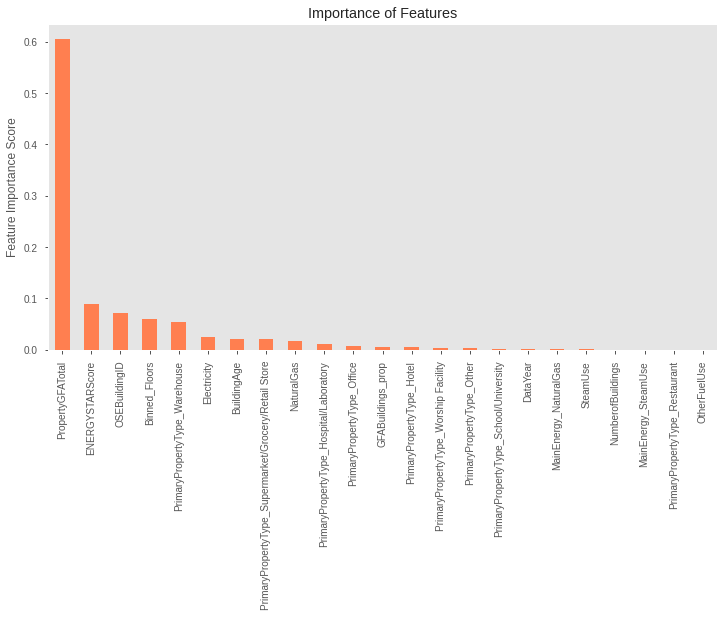

In [74]:
feat_imp = pd.Series(rf_grid.best_estimator_.feature_importances_, list(X2_train)).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar', title='Importance of Features', color= 'coral')
plt.ylabel('Feature Importance Score')
plt.grid()
plt.show()

### Gradient Boosting

##### Training
We will first traing the GBM regressor with the default parameter values, then we will try optimizing its parameters.



In [75]:
gbm1 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=3,
                                 subsample=1.0, max_features= None, random_state=101)
gbm2 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=3,
                                 subsample=1.0, max_features= None, random_state=101)
gbm4 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=3,
                                 subsample=1.0, max_features= None, random_state=101)

gbm1.fit(X_train, y_train)
gbm2.fit(X2_train, y2_train)
gbm4.fit(X4_train, y4_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=101, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

##### Prediction


In [76]:
gbm1_pred = gbm1.predict(X_test)
gbm2_pred = gbm2.predict(X2_test)
gbm4_pred = gbm4.predict(X4_test)

##### Evaluation


Gradiant Boosting Performance:

With duplicates, No logging:
MAE: 2663686.241527624
RMSE: 7221083.479731504
R2_Score:  0.845730167331695

With duplicates, With logging:
MAE: 0.3309762030739993
RMSE: 0.45041473320709063
R2_Score:  0.8852555724100915

No duplicates, With logging:
MAE: 0.32323542050187065
RMSE: 0.48863997740026127
R2_Score:  0.8568804023109492


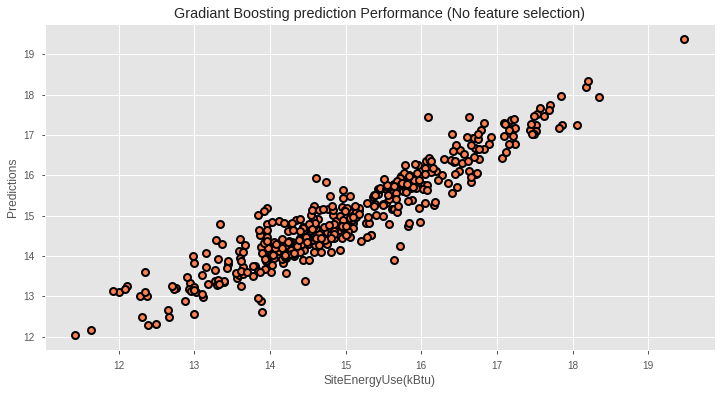

In [77]:
print('Gradiant Boosting Performance:')

print('\nWith duplicates, No logging:')
print('MAE:', metrics.mean_absolute_error(y_test, gbm1_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, gbm1_pred)))
print('R2_Score: ', metrics.r2_score(y_test, gbm1_pred))

print('\nWith duplicates, With logging:')
print('MAE:', metrics.mean_absolute_error(y2_test, gbm2_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2_test, gbm2_pred)))
print('R2_Score: ', metrics.r2_score(y2_test, gbm2_pred))

print('\nNo duplicates, With logging:')
print('MAE:', metrics.mean_absolute_error(y4_test, gbm4_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y4_test, gbm4_pred)))
print('R2_Score: ', metrics.r2_score(y4_test, gbm4_pred))

fig = plt.figure(figsize=(12, 6))
plt.scatter(y2_test,gbm2_pred,color='coral', linewidths=2, edgecolors='k')
plt.xlabel('SiteEnergyUse(kBtu)') 
plt.ylabel('Predictions') 
plt.title('Gradiant Boosting prediction Performance (No feature selection)') 
plt.grid(True)
plt.show()

##### SUMMARY OF RESULTS

In [ ]:
regressors = [('Ridge', Ridge(random_state=seed), [{'alpha': np.logspace(-5, 5, 200)}]),

              ('Lasso', Lasso(random_state=seed), [{'alpha': np.logspace(-5, 5, 200)}]), 

              ('Decision-Tree', DecisionTreeRegressor(random_state=seed), [{'max_depth': [4, 8, 12],
                                                                            'min_samples_split': [20, 50, 100]}]),

              ('RandomForest', RandomForestRegressor(random_state=seed), [{'max_depth': [8, 10, 12], 
                                                                           'min_samples_split': [10, 12, 14],
                                                                           'n_estimators': [200, 500, 1000]}]),

              ('GradientBoosting', GradientBoostingRegressor(random_state=seed), [{'max_depth': [4, 6, 8,], 
                                                                                   'min_samples_split': [200, 500, 1000], 
                                                                                   'n_estimators': [50, 100, 200]}])]
                                                                                   
evaluate_estimators(X2_train, X2_test, y2_train, y2_test, regressors, cv=5, scoring='neg_root_mean_squared_error', target_name='EnergyUse')

## 4. Modelization of the CO2


In [79]:
df_final_co2 = df_final.copy()
logl = ['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']

for i in logl:
    df_final_co2[i + '_log'] = np.log(df_final_co2[i])
    df_final_co2.drop(i, axis=1, inplace=True)

y = df_final_co2['GHGEmissions(MetricTonsCO2e)_log']
X = df_final_co2.drop(['SiteEnergyUse(kBtu)_log','GHGEmissions(MetricTonsCO2e)_log'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

Training

In [80]:
rf_co2 = RandomForestRegressor(random_state=101, n_estimators=200)
rf_co2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=101, verbose=0, warm_start=False)

Prediction

In [82]:
rf_co2_pred = rf_co2.predict(X_test)

Evaluation

Random Forest Performance:

With duplicates, No logging:
MAE: 0.289309588095937
RMSE: 0.4230692379678811
R2_Score:  0.9221886931166413


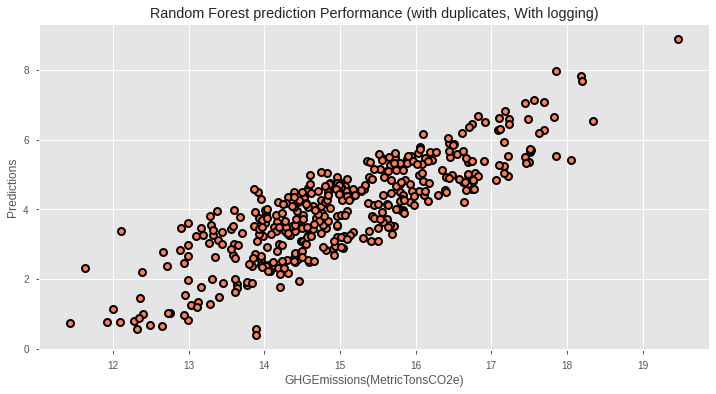

In [83]:
print('Random Forest Performance:')

print('\nWith duplicates, No logging:')
print('MAE:', metrics.mean_absolute_error(y_test, rf_co2_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf_co2_pred)))
print('R2_Score: ', metrics.r2_score(y_test, rf_co2_pred))

fig = plt.figure(figsize=(12, 6))

plt.scatter(y2_test,rf_co2_pred,color='coral', linewidths=2, edgecolors='k')
plt.xlabel('GHGEmissions(MetricTonsCO2e)') 
plt.ylabel('Predictions') 
plt.title('Random Forest prediction Performance (with duplicates, With logging)') 
plt.grid(True)
plt.show()

Features Importance

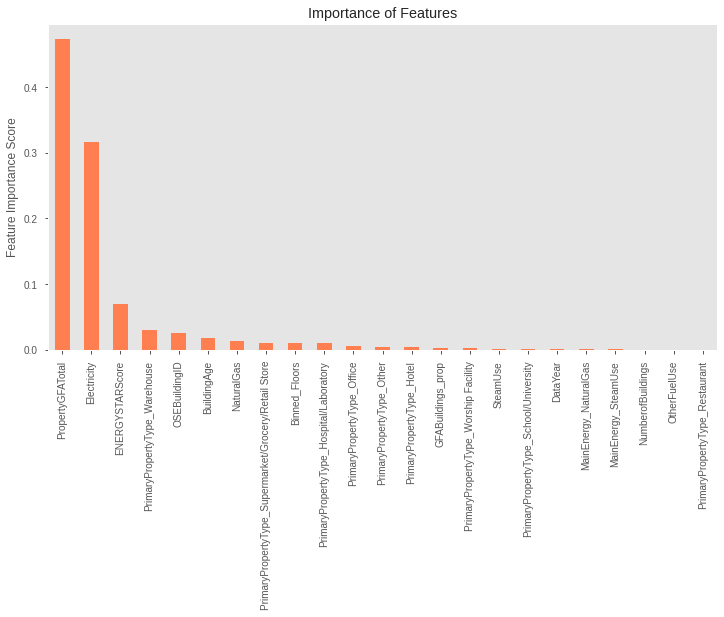

In [84]:
feat_imp = pd.Series(rf_co2.feature_importances_, list(X_train)).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar', title='Importance of Features', color= 'coral')
plt.ylabel('Feature Importance Score')
plt.grid()
plt.show()

CV sur les autres model

Metrics sur le temps pour la modelisation

import time
start_time = time.time()
main()
print("--- %s seconds ---" % (time.time() - start_time))

Energy star score 